In [1]:
import open3d as o3d
import numpy as np
import os
import glob
import pandas as pd
import pymeshlab as pml
import time
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [85]:
def o3d_to_pml(mesh):
    tmp_file_name = "temp.obj"
    o3d.io.write_triangle_mesh(tmp_file_name, mesh)
    # if not os.path.exists(tmp_file_name):
    #     print(f"File '{tmp_file_name}' doesn't exist. Waiting for 1 second...")
    #     time.sleep(1)    
    mesh_pml = pml.MeshSet()
    mesh_pml.load_new_mesh(tmp_file_name)
    os.remove(tmp_file_name)
    return mesh_pml

In [86]:
def pml_to_o3d(mesh):
    tmp_file_name = "temp.obj"

    mesh.save_current_mesh(tmp_file_name)
    # if not os.path.exists(tmp_file_name):
    #     print(f"File '{tmp_file_name}' doesn't exist. Waiting for 1 second...")
    #     time.sleep(1)   
    mesh_o3d = o3d.io.read_triangle_mesh(tmp_file_name)
    os.remove(tmp_file_name)
    return mesh_o3d

Start building a simple tool that checks all shapes in the database. The tool should output, for each shape

-   the class of the shape
-   the number of faces and vertices of the shape
-   the type of faces (e.g. only triangles, only quads, mixes of triangles and quads)
-   the axis-aligned 3D bounding box of the shapes

In [1]:
def viz_mesh(obj_file_path, vis_option = "wireframe_on_shaded"):   
        
        if isinstance(obj_file_path, str):
            mesh = o3d.io.read_triangle_mesh(obj_file_path)
        else:
             mesh = obj_file_path
        mesh.compute_vertex_normals() 
        if vis_option == "smoothshade":
            o3d.visualization.draw_geometries([mesh], width=1280, height=720)
        elif vis_option == "wireframe_on_shaded":
            o3d.visualization.draw_geometries([mesh], width=1280, height=720, mesh_show_wireframe=True)
        elif vis_option == "wireframe":
            # We first need to obtain a lineset of the wireframe if we don't want to render the mesh itself
            wireframe = o3d.geometry.LineSet.create_from_triangle_mesh(mesh) 
            o3d.visualization.draw_geometries([wireframe], width=1280, height=720)
        elif vis_option == "world_axes":
            # Display the mesh including a world axis system.

            # Create the endpoints of each line. Each line is unit-length.
            # For the world axes, the origin is shared by all lines. So we have 4 endpoints in total
            line_endpoints = [
                [0, 0, 0],
                [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1]
            ]

            # List of indices into the 'line_endpoints' list, which describes which endpoints form which line
            line_indices = [[0, 1], [0, 2], [0, 3]]

            # Create a line set from the endpoints and indices
            world_axes = o3d.geometry.LineSet(
                points=o3d.utility.Vector3dVector(line_endpoints),
                lines=o3d.utility.Vector2iVector(line_indices),
            )

            # Render the line set and the mesh
            o3d.visualization.draw_geometries([mesh, world_axes], width=1280, height=720)
        elif vis_option == "black_background":
            # Create visualizer
            vis = o3d.visualization.Visualizer()
            vis.create_window()
            vis.add_geometry(mesh)

            # Set render options (e.g. background color)
            opt = vis.get_render_option()
            opt.background_color = np.asarray([0, 0, 0])

            # Run the visualizer
            vis.run()
            vis.destroy_window()


In [ ]:
viz_mesh(obj_file_path, vis_option = "wireframe_on_shaded")

In [2]:
dbpath = r"./database/"
mesh_path = dbpath + r"Sign/m1675.obj"

mesh_data = []

for class_folder in os.listdir(dbpath):
    # Construct the full path to the subfolder
    class_folder_path = os.path.join(dbpath, class_folder)
    
    # Check if the item in the directory is a directory (to skip files)
    if os.path.isdir(class_folder_path):
        # Assuming the class folder name is the class name
        class_name = class_folder
        
        # Iterate through .obj files in the subfolder
        for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
            
            mesh = o3d.io.read_triangle_mesh(obj_file_path)
            filename = obj_file_path.split("\\")[-1]
            vertices = np.asarray(mesh.vertices)
            triangles = np.asarray(mesh.triangles)
            filepath = class_folder_path
            mesh_data.append([class_name, filename, len(vertices), len(triangles), obj_file_path])

            print(f"Class: {class_name}, Vertices: {len(vertices)}, Triangles: {len(triangles)}")
df = pd.DataFrame(mesh_data, columns=["Class", "Filename", "Vertices", "Triangles", "Filepath"])
print(df)
import pickle
df.to_pickle("dataframe.pkl")

Class: AircraftBuoyant, Vertices: 201, Triangles: 340
Class: AircraftBuoyant, Vertices: 8761, Triangles: 16960
Class: AircraftBuoyant, Vertices: 1878, Triangles: 6173
Class: AircraftBuoyant, Vertices: 778, Triangles: 1457
Class: AircraftBuoyant, Vertices: 425, Triangles: 824
Class: AircraftBuoyant, Vertices: 1252, Triangles: 2305
Class: AircraftBuoyant, Vertices: 178, Triangles: 344
Class: AircraftBuoyant, Vertices: 1093, Triangles: 1930
Class: AircraftBuoyant, Vertices: 3174, Triangles: 6000
Class: AircraftBuoyant, Vertices: 742, Triangles: 1375
Class: AircraftBuoyant, Vertices: 3055, Triangles: 6274
Class: AircraftBuoyant, Vertices: 795, Triangles: 1382
Class: AircraftBuoyant, Vertices: 432, Triangles: 640
Class: AircraftBuoyant, Vertices: 1097, Triangles: 1976
Class: AircraftBuoyant, Vertices: 12987, Triangles: 24466
Class: AircraftBuoyant, Vertices: 3298, Triangles: 6348
Class: Apartment, Vertices: 14865, Triangles: 21021
Class: Apartment, Vertices: 20462, Triangles: 42064
Class: A

In [9]:
df = pd.read_pickle("dataframe.pkl")


Min, Max and average Number of triangles and Vertices over the entire dataset

In [10]:
"Min. Vertices:", df["Vertices"].min(), "Max. Vertices:", df["Vertices"].max(), "Avg. Vertices", df["Vertices"].mean()

('Min. Vertices:',
 16,
 'Max. Vertices:',
 73440,
 'Avg. Vertices',
 5025.5453080950465)

In [11]:
"Min. Triangles:", df["Triangles"].min(), "Max. Triangles:", df["Triangles"].max(), "Avg. Triangles", df["Triangles"].mean()

('Min. Triangles:',
 16,
 'Max. Triangles:',
 129881,
 'Avg. Triangles',
 10691.52597664116)

### The type of faces (e.g. only triangles, only quads, mixes of triangles and quads)

In [7]:
test_face_type = False

if test_face_type:
    dbpath = r"./database/"    
    for class_folder in os.listdir(dbpath):
        # Construct the full path to the subfolder
        class_folder_path = os.path.join(dbpath, class_folder)
        
        # Check if the item in the directory is a directory (to skip files)
        if os.path.isdir(class_folder_path):
            # Assuming the class folder name is the class name
            class_name = class_folder
            
            # Iterate through .obj files in the subfolder
            for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
                # Read the .obj file using tripy
                # mesh = o3d.io.read_triangle_mesh(obj_file_path)
                with open(obj_file_path, 'r') as file:
                # Iterate through each line in the file
                    for line in file:
                        # Check if the line starts with 'f' (case-sensitive)
                        if line.startswith('f'):
                            if len(line.split(" "))!= 4:
                                print(len(line.split(" ")))

                # print(f"Class: {class_name}, Vertices: {len(vertices)}, Triangles: {len(triangles)}")

The codes iterates through the dataset and would print out something if a face has more or less than 3 vertices. Since it didnt print out anything, its only Triangles

### Axis-aligned bouding box

In [12]:
dbpath = r"./database/"

mesh_path = dbpath + r"Sign/m1675.obj"
mesh = o3d.io.read_triangle_mesh(mesh_path)
mesh.compute_vertex_normals()
aabb = mesh.get_axis_aligned_bounding_box()


# Get the minimum and maximum coordinates of the AABB
min_coords = aabb.get_min_bound()
max_coords = aabb.get_max_bound()

# Define the eight corners of the AABB
vertices = [
    min_coords,
    [max_coords[0], min_coords[1], min_coords[2]],
    [max_coords[0], max_coords[1], min_coords[2]],
    [min_coords[0], max_coords[1], min_coords[2]],
    [min_coords[0], min_coords[1], max_coords[2]],
    [max_coords[0], min_coords[1], max_coords[2]],
    max_coords,
    [min_coords[0], max_coords[1], max_coords[2]]
]

# Define the edges of the AABB
lines = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0],
    [4, 5],
    [5, 6],
    [6, 7],
    [7, 4],
    [0, 4],
    [1, 5],
    [2, 6],
    [3, 7]
]

# Create a LineSet to visualize the AABB
aabb_line_set = o3d.geometry.LineSet()
aabb_line_set.points = o3d.utility.Vector3dVector(vertices)
aabb_line_set.lines = o3d.utility.Vector2iVector(lines)

# Customize the bounding box appearance
line_set_color = np.array([1.0, 0.0, 0.0])  # Red color (R, G, B)
line_set_line_width = 5.0  # Adjust line width as needed

# Set the line set's color and line width
aabb_line_set.paint_uniform_color(line_set_color)
# aabb_line_set.line_width = line_set_line_width

# Visualize the object and its AABB
o3d.visualization.draw_geometries([mesh, aabb_line_set])

### Histogram

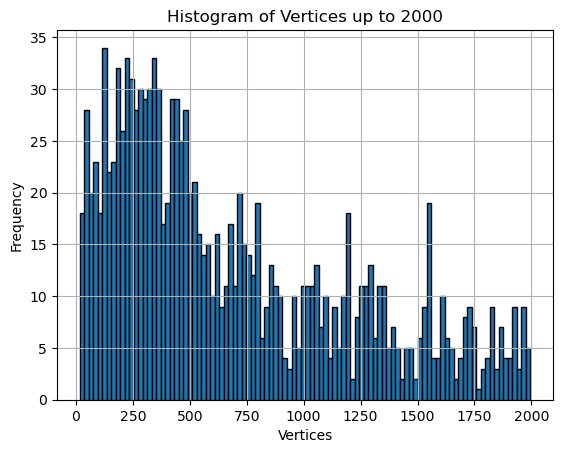

In [12]:
import matplotlib.pyplot  as plt
# Create a histogram
plt.hist(df[df['Vertices'] < 2000]['Vertices'], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Vertices')
plt.ylabel('Frequency')
plt.title('Histogram of Vertices up to 2000')
plt.grid(True)

# Display the histogram
plt.show()

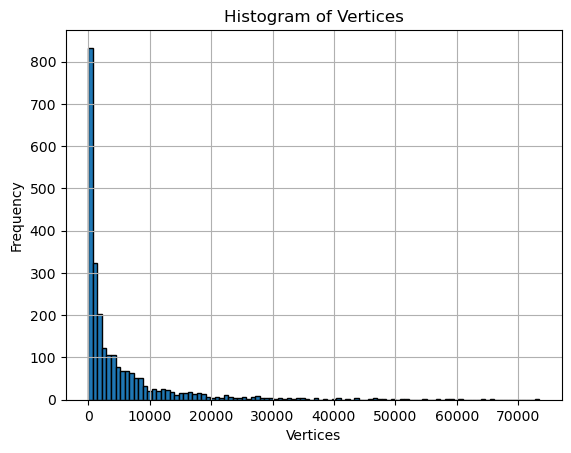

In [14]:
import matplotlib.pyplot  as plt
# Create a histogram
plt.hist(df['Vertices'], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Vertices')
plt.ylabel('Frequency')
plt.title('Histogram of Vertices')
plt.grid(True)

# Display the histogram
plt.show()

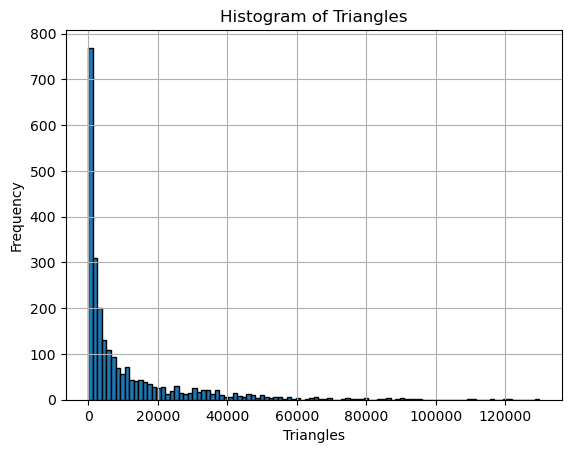

In [15]:
# Create a histogram
plt.hist(df["Triangles"], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Triangles')
plt.ylabel('Frequency')
plt.title('Histogram of Triangles')
plt.grid(True)

# Display the histogram
plt.show()

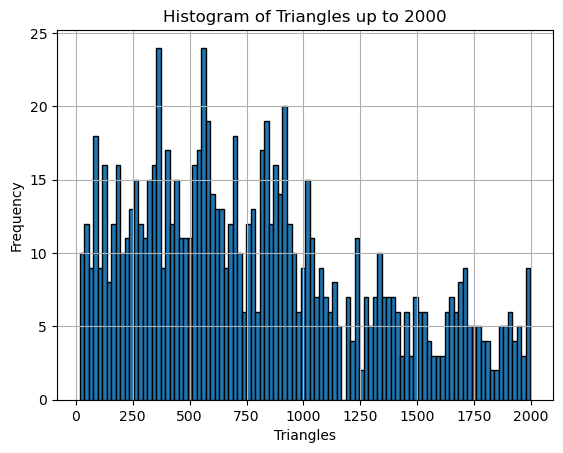

In [14]:
import matplotlib.pyplot  as plt
# Create a histogram
plt.hist(df[df['Triangles'] < 2000]["Triangles"], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Triangles')
plt.ylabel('Frequency')
plt.title('Histogram of Triangles up to 2000')
plt.grid(True)

# Display the histogram
plt.show()

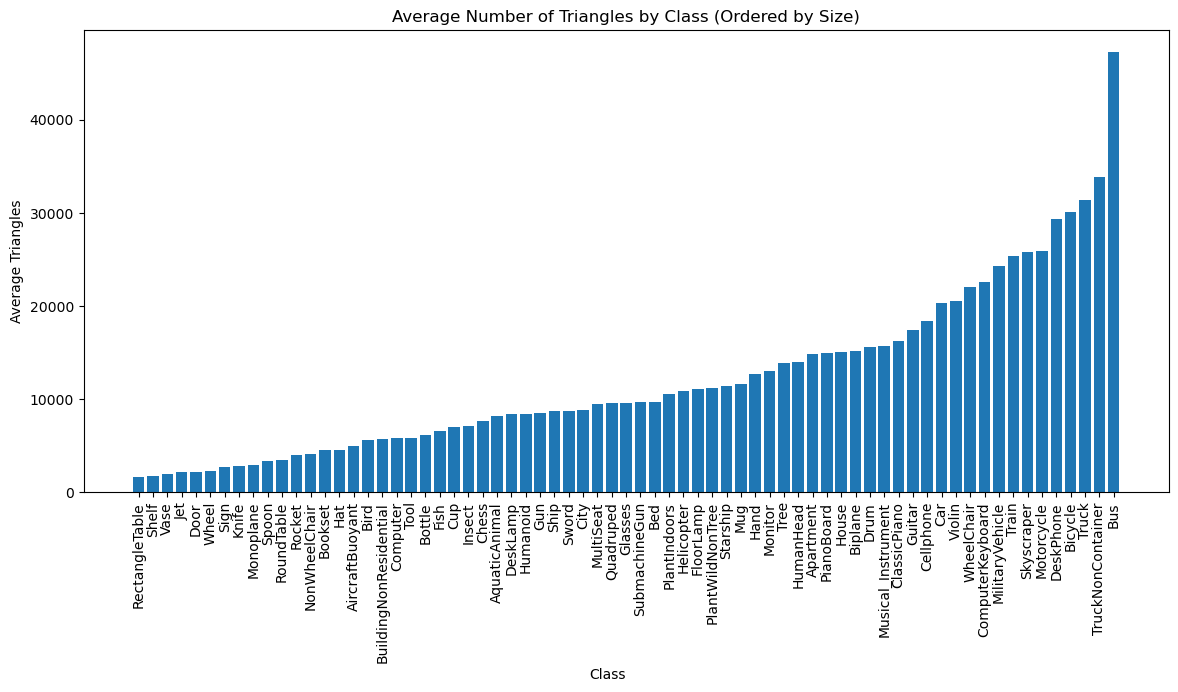

In [ ]:
average_triangles = df.groupby('Class')['Triangles'].mean().reset_index()

# Sort the DataFrame by average Triangles in descending order
average_triangles = average_triangles.sort_values(by='Triangles', ascending=True)


# Create a bar chart with angled x-axis labels
plt.figure(figsize=(14, 6))
plt.bar(average_triangles['Class'], average_triangles['Triangles'])
plt.xlabel('Class', ha='right')  # Angle the x-axis labels
plt.xticks(rotation=90)
plt.ylabel('Average Triangles')
plt.title('Average Number of Triangles by Class (Ordered by Size)')
plt.show()

### Outliers

In [17]:
highVertexDf = df[df['Vertices'] > 50000]
highVertexDf

,Class,Filename,Vertices,Triangles,Filepath
100,Bicycle,D00462.obj,56754,111471,./database/Bicycle\D00462.obj
143,Biplane,m1120.obj,65722,129881,./database/Biplane\m1120.obj
366,Car,m1510.obj,54710,109357,./database/Car\m1510.obj
396,Car,m1544.obj,60326,116378,./database/Car\m1544.obj
457,Chess,m1595.obj,60667,121343,./database/Chess\m1595.obj
944,Helicopter,m1308.obj,58392,116773,./database/Helicopter\m1308.obj
1705,PlantIndoors,D00080.obj,64126,34887,./database/PlantIndoors\D00080.obj
1791,PlantWildNonTree,m985.obj,50833,88945,./database/PlantWildNonTree\m985.obj
2095,Skyscraper,D00058.obj,73440,53448,./database/Skyscraper\D00058.obj
2103,Skyscraper,D00520.obj,51626,52041,./database/Skyscraper\D00520.obj


In [18]:
highTrianglesDf = df[df['Triangles'] > 100000]
highTrianglesDf

,Class,Filename,Vertices,Triangles,Filepath
100,Bicycle,D00462.obj,56754,111471,./database/Bicycle\D00462.obj
143,Biplane,m1120.obj,65722,129881,./database/Biplane\m1120.obj
366,Car,m1510.obj,54710,109357,./database/Car\m1510.obj
396,Car,m1544.obj,60326,116378,./database/Car\m1544.obj
406,Car,m1556.obj,35131,119540,./database/Car\m1556.obj
457,Chess,m1595.obj,60667,121343,./database/Chess\m1595.obj
944,Helicopter,m1308.obj,58392,116773,./database/Helicopter\m1308.obj


In [19]:
lowVertexDf = df[df['Vertices'] < 25]
lowVertexDf

,Class,Filename,Vertices,Triangles,Filepath
665,Door,D01121.obj,16,16,./database/Door\D01121.obj
676,Door,D01194.obj,18,18,./database/Door\D01194.obj
678,Door,m1708.obj,16,16,./database/Door\m1708.obj
716,Drum,D00709.obj,24,132,./database/Drum\D00709.obj
996,House,m434.obj,22,26,./database/House\m434.obj
1587,MultiSeat,m784.obj,24,36,./database/MultiSeat\m784.obj
2261,Tool,m1102.obj,24,52,./database/Tool\m1102.obj


In [20]:
lowTrianglesDf = df[df['Triangles'] < 25]
lowTrianglesDf

,Class,Filename,Vertices,Triangles,Filepath
665,Door,D01121.obj,16,16,./database/Door\D01121.obj
676,Door,D01194.obj,18,18,./database/Door\D01194.obj
678,Door,m1708.obj,16,16,./database/Door\m1708.obj
1015,House,m462.obj,25,22,./database/House\m462.obj


### Resampling outliers

We want all objects to have a similar amount of Vertices, be centered, scaled to a unit cube and rotated by their eigenvectors in order to be used for the following steps. 

In [87]:
import pymeshlab as pml

In [88]:
def translate_to_center(mesh):
    """
    Translate the mesh so that center is at the coordinate-frame origin.
    """
    mesh.translate(-mesh.get_center())
    return mesh

In [89]:
def scale_unitcube(mesh):
    """
    Scale mesh to fit in a unit-sized cube.
    """
    center = mesh.get_center()

    #test is mesh is centered at origin
    if center[0] > 0.001 or center[1] > 0.001 or center[2] > 0.001:
        raise ValueError(
            f'Mesh must be centered at origin'
        )
    factor = 1 / max(mesh.get_max_bound() - mesh.get_min_bound())
    print("Factor: ", factor)
    mesh.scale(factor, center)
    return mesh

In [90]:
def get_eigen_vectors(mesh):
    # Load the mesh with open3d
    
    # mesh.compute_vertex_normals()
    #mesh.rotate(mesh.get_rotation_matrix_from_xyz((0, np.pi/4, np.pi/5)))

    # Obtain numpy array containing the mesh's vertex positions.
    # Note: modifying values in the array will also change the corresponding vertex
    # positions in the mesh object
    vertices = np.asarray(mesh.vertices)

    # Compute barycenter
    barycenter = np.mean(vertices, axis=0)

    # Align mesh and vertices to origin
    vertices -= barycenter

    # Compute covariance matrix on vertices array
    cov = np.cov(vertices.transpose())

    # Compute eigen vectors and eigen values of covariance matrix
    # The eigen vectors are the columns of the returned 2d-array
    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # Order the eigenvectors according to the magnitude of their corresponding eigen value
    # (from largest to smallest)
    eigencombined = [(eigenvalues[i], eigenvectors[:, i]) for i in range(3)]
    eigencombined.sort(key=lambda x:x[0], reverse=True)
    eigenvectors = [item[1] for item in eigencombined]
    eigenvalues = [item[0] for item in eigencombined]

    # Replace the minor eigen vector with cross product of major and medium (to enforce right-handed reference frame)
    eigenvectors.pop(2)
    eigenvectors.append(np.cross(eigenvectors[0], eigenvectors[1]))

    eigvec_startpoint = np.zeros(3)
    eigvec_points = [eigvec_startpoint] + [vec for vec in eigenvectors]
    eigvec_line_indices = [[0, 1], [0, 2], [0, 3]]
    eigvec_lineset = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(eigvec_points),
        lines=o3d.utility.Vector2iVector(eigvec_line_indices),
    )

    # Add colors to the lines
    # Red, green, blue for major, 2nd-, and 3rd-largest eigen vectors, respectively. 
    line_colors = np.array([[255,0,0], [0,255,0], [0,0,255]])
    eigvec_lineset.colors = o3d.utility.Vector3dVector(line_colors)

    return eigenvectors, eigvec_lineset

In [44]:
import copy
def transform(mesh):
    eigen_vectors,_ = get_eigen_vectors(mesh)
   
    mesh_r = copy.deepcopy(mesh)

    mesh_r.rotate(eigen_vectors, center=(0, 0, 0))

    """below this line is for visualisation"""
    # Display the mesh including a world axis system.

    # Create the endpoints of each line. Each line is unit-length.
    # For the world axes, the origin is shared by all lines. So we have 4 endpoints in total
    line_endpoints = [
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
    

    # List of indices into the 'line_endpoints' list, which describes which endpoints form which line
    line_indices = [[0, 1], [0, 2], [0, 3]]

    # Create a line set from the endpoints and indices
    world_axes = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(line_endpoints),
        lines=o3d.utility.Vector2iVector(line_indices),
    )
    # world_axes = o3d.geometry.TriangleMesh.create_coordinate_frame() 

    # Render the line set and the mesh
    # o3d.visualization.draw_geometries([ mesh_r, world_axes], width=1280, height=720, mesh_show_wireframe=True)
    return mesh_r

mesh = o3d.io.read_triangle_mesh("./database/Rocket/D00015.obj")
transform(mesh)

TriangleMesh with 88 points and 156 triangles.

In [91]:
#flip
def flip_mesh(mesh):
    mass = [0, 0, 0]
    for triangle in mesh.triangles:
        center = [0, 0, 0]
        for v in triangle:
            vertex = mesh.vertices[v]
            center += vertex
        center = center / 3
        
        for i, C in enumerate(center):
            mass[i] += np.sign(C) * (C * C)
    flip_matrix = np.asarray(
        [[1, 0, 0, 0],
         [0, 1, 0, 0],
         [0, 0, 1, 0],
         [0, 0, 0, 1]]
    )
    for i, C in enumerate(mass):
        if C > 0:
            print("flipped")
            flip_matrix[i, i] = -1

    return mesh.transform(flip_matrix)

In [92]:
def remesh_increase(mesh, targetlen=0.02, iterations=3):
    # print(f"Vertices before: {mesh.current_mesh().vertex_number()}, Faces before: {mesh.current_mesh().face_number()}")
    # print(f"Refining mesh ({iterations} iterations)... ")
    mesh.meshing_isotropic_explicit_remeshing(
        targetlen=pml.AbsoluteValue(targetlen), iterations=iterations)

    vAfter = mesh.current_mesh().vertex_number()
    fAfter = mesh.current_mesh().face_number()
    # print(f"Vertices after: {vAfter}, Faces after: {fAfter}")
    return mesh

In [93]:
def remesh(mesh, classname, filename, target_vertices=2000, factor=0.3):
    # mesh = pml.MeshSet()
    # mesh.load_new_mesh(mesh_path)
    print(f"Vertices before: {mesh.current_mesh().vertex_number()}, Faces before: {mesh.current_mesh().face_number()}")

    # if mesh.current_mesh().vertex_number() < target_vertices * (1-factor):
    count = 0
    while mesh.current_mesh().vertex_number() < target_vertices* (1-factor) and count < 5:#not in range(int(target_vertices*(1-factor)), int(target_vertices*(1+factor))):
        count += 1
        remesh_increase(mesh)

    if mesh.current_mesh().vertex_number() > target_vertices* (1+factor):
        mesh.meshing_decimation_quadric_edge_collapse(targetfacenum=int(target_vertices*1.4))

    newFilePath = f"./resampled/{classname}/{filename}"

    if not os.path.exists(f"./resampled/{classname}"):
        os.makedirs(f"./resampled/{classname}")

    mesh = o3d_to_pml(transform(flip_mesh(pml_to_o3d(mesh))))
    mesh.save_current_mesh(newFilePath)

    vAfter = mesh.current_mesh().vertex_number()
    fAfter = mesh.current_mesh().face_number()
    print(f"Vertices after: {vAfter}, Faces after: {fAfter}")
    return mesh, vAfter, fAfter, newFilePath
            

Runs through all the folders and computes the transformations and remeshing on each object, which is saved in the resampled folder. If theres an error at converting it is saved in log.txt

In [ ]:
dbpath = r"./database/"
log = open("./log.txt", "a")
for class_folder in os.listdir(dbpath):
    # Construct the full path to the subfolder
    class_folder_path = os.path.join(dbpath, class_folder)
    
    # Check if the item in the directory is a directory (to skip files)
    if os.path.isdir(class_folder_path):
        # Assuming the class folder name is the class name
        class_name = class_folder
        
        # Iterate through .obj files in the subfolder
        for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
            try:
                mesh = pml.MeshSet()
                mesh.load_new_mesh(obj_file_path)
                mesh = o3d_to_pml(scale_unitcube(translate_to_center(pml_to_o3d(mesh))))
                remesh(mesh, class_name, obj_file_path.split("\\")[-1], 2000, 0.3)
            except:
                print(f"Failed to convert {obj_file_path}", file=log)
log.close()

Create a new dataframe with the transformed data

In [17]:
dbpath = r"./resampled/"
mesh_data2 = []
for class_folder in os.listdir(dbpath):
    # Construct the full path to the subfolder
    class_folder_path = os.path.join(dbpath, class_folder)

    # Check if the item in the directory is a directory (to skip files)
    if os.path.isdir(class_folder_path):
        # Assuming the class folder name is the class name
        class_name = class_folder

        # Iterate through .obj files in the subfolder
        for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
            
            mesh = o3d.io.read_triangle_mesh(obj_file_path)
            filename = obj_file_path.split("\\")[-1]
            vertices = np.asarray(mesh.vertices)
            triangles = np.asarray(mesh.triangles)
            filepath = class_folder_path
            mesh_data2.append([class_name, filename, len(vertices), len(triangles), obj_file_path])

            print(f"Class: {class_name}, Vertices: {len(vertices)}, Triangles: {len(triangles)}")
df2 = pd.DataFrame(mesh_data2, columns=["Class", "Filename", "Vertices", "Triangles", "Filepath"])
df2.to_pickle("dataframe_resampled.pkl")
df2

Class: AircraftBuoyant, Vertices: 1440, Triangles: 2800
Class: AircraftBuoyant, Vertices: 1445, Triangles: 2799
Class: AircraftBuoyant, Vertices: 1878, Triangles: 6173
Class: AircraftBuoyant, Vertices: 2255, Triangles: 4414
Class: AircraftBuoyant, Vertices: 1914, Triangles: 3792
Class: AircraftBuoyant, Vertices: 1436, Triangles: 2799
Class: AircraftBuoyant, Vertices: 1406, Triangles: 2800
Class: AircraftBuoyant, Vertices: 1433, Triangles: 2800
Class: AircraftBuoyant, Vertices: 1560, Triangles: 2800
Class: AircraftBuoyant, Vertices: 2080, Triangles: 4050
Class: AircraftBuoyant, Vertices: 1398, Triangles: 2799
Class: AircraftBuoyant, Vertices: 1880, Triangles: 3644
Class: AircraftBuoyant, Vertices: 2374, Triangles: 4650
Class: AircraftBuoyant, Vertices: 2497, Triangles: 4887
Class: AircraftBuoyant, Vertices: 1657, Triangles: 2800
Class: AircraftBuoyant, Vertices: 1455, Triangles: 2799
Class: Apartment, Vertices: 2337, Triangles: 2800
Class: Apartment, Vertices: 1264, Triangles: 2800
Clas

,Class,Filename,Vertices,Triangles,Filepath
0,AircraftBuoyant,m1337.obj,1440,2800,./resampled/AircraftBuoyant\m1337.obj
1,AircraftBuoyant,m1338.obj,1445,2799,./resampled/AircraftBuoyant\m1338.obj
2,AircraftBuoyant,m1339.obj,1878,6173,./resampled/AircraftBuoyant\m1339.obj
3,AircraftBuoyant,m1340.obj,2255,4414,./resampled/AircraftBuoyant\m1340.obj
4,AircraftBuoyant,m1341.obj,1914,3792,./resampled/AircraftBuoyant\m1341.obj
...,...,...,...,...,...
2471,WheelChair,D00687.obj,1454,2800,./resampled/WheelChair\D00687.obj
2472,WheelChair,D00720.obj,1570,2799,./resampled/WheelChair\D00720.obj
2473,WheelChair,D00782.obj,1558,2799,./resampled/WheelChair\D00782.obj
2474,WheelChair,D00821.obj,1454,2800,./resampled/WheelChair\D00821.obj


### Statistics after resampling

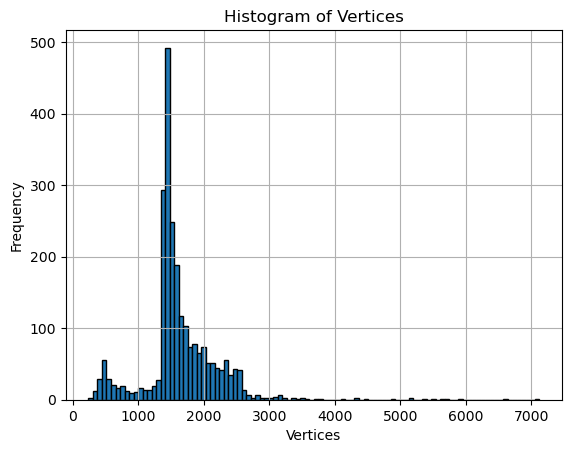

In [18]:
# Create a histogram
plt.hist(df2['Vertices'], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Vertices')
plt.ylabel('Frequency')
plt.title('Histogram of Vertices')
plt.grid(True)

# Display the histogram
plt.show()

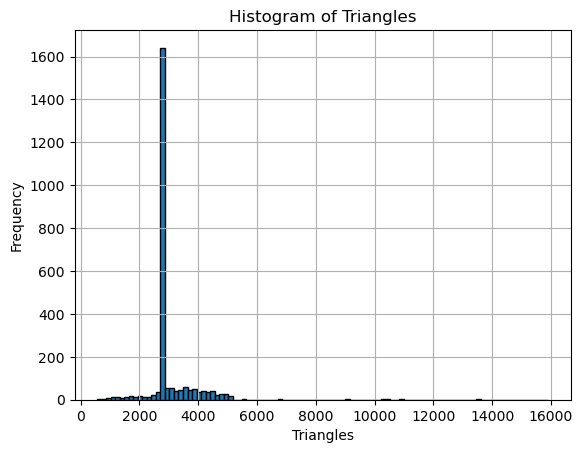

In [19]:
# Create a histogram
plt.hist(df2['Triangles'], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Triangles')
plt.ylabel('Frequency')
plt.title('Histogram of Triangles')
plt.grid(True)

# Display the histogram
plt.show()

In [20]:
"Min. Vertices:", df["Vertices"].min(), "Max. Vertices:", df["Vertices"].max(), "Avg. Vertices", df["Vertices"].mean()

('Min. Vertices:',
 16,
 'Max. Vertices:',
 73440,
 'Avg. Vertices',
 5025.5453080950465)

In [21]:
"Min. Triangles:", df["Triangles"].min(), "Max. Triangles:", df["Triangles"].max(), "Avg. Triangles", df["Triangles"].mean()

('Min. Triangles:',
 16,
 'Max. Triangles:',
 129881,
 'Avg. Triangles',
 10691.52597664116)

Lets view two objects, before and after the transformation:

In [22]:
viz_mesh("./database/Rocket/D00015.obj")

In [23]:
viz_mesh("./resampled/Rocket/D00015.obj")

***Test bary center normalization***

In [106]:
import math
def distance(x1, y1, z1, x2, y2, z2):
      
    d = math.sqrt(math.pow(x2 - x1, 2) +
                math.pow(y2 - y1, 2) +
                math.pow(z2 - z1, 2)* 1.0)
    return d

def center_test(dbpath):
    dist_to_center_list = []

    for class_folder in os.listdir(dbpath):
        # Construct the full path to the subfolder
        class_folder_path = os.path.join(dbpath, class_folder)
        
        # Check if the item in the directory is a directory (to skip files)
        if os.path.isdir(class_folder_path):
            # Assuming the class folder name is the class name
            class_name = class_folder
            
            # Iterate through .obj files in the subfolder
            for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
                mesh = o3d.io.read_triangle_mesh(obj_file_path)
                
                #compute mesh center and distance to origin, add this to the list
                mesh_center = mesh.get_center()
                dist = distance(mesh_center[0], mesh_center[1], mesh_center[2], 0, 0, 0)
                dist_to_center_list.append(dist)          
    return dist_to_center_list


In [107]:
#compute histogram for origional database
dbpath = r"./database/"
dist_to_center_list = center_test(dbpath)

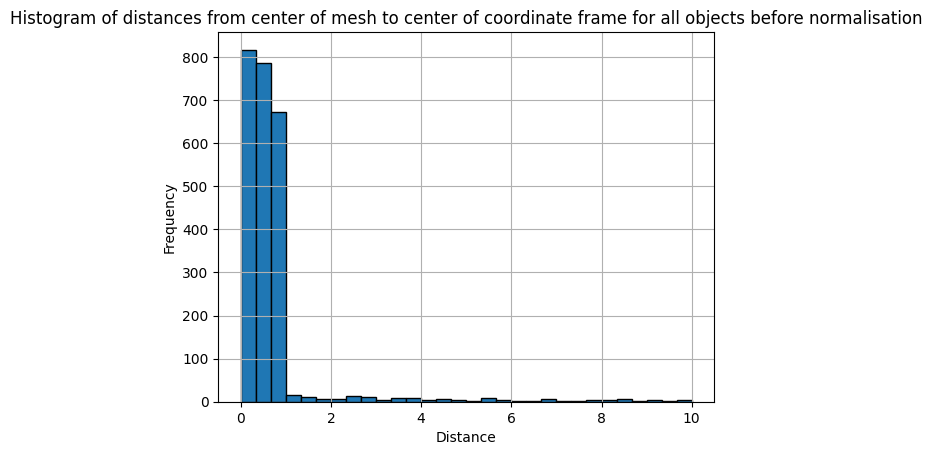

In [108]:
plt.hist(dist_to_center_list, bins=30, range=[0, 10], edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Distance')
plt.title('Histogram of distances from center of mesh to center of coordinate frame for all objects before normalisation')
plt.grid(True)

# Display the histogram
plt.show()

In [109]:
#needs to be all 0 when centering is executed correctly
dbpath = r"./resampled3/"
dist_to_center_list_normailzed = center_test(dbpath)

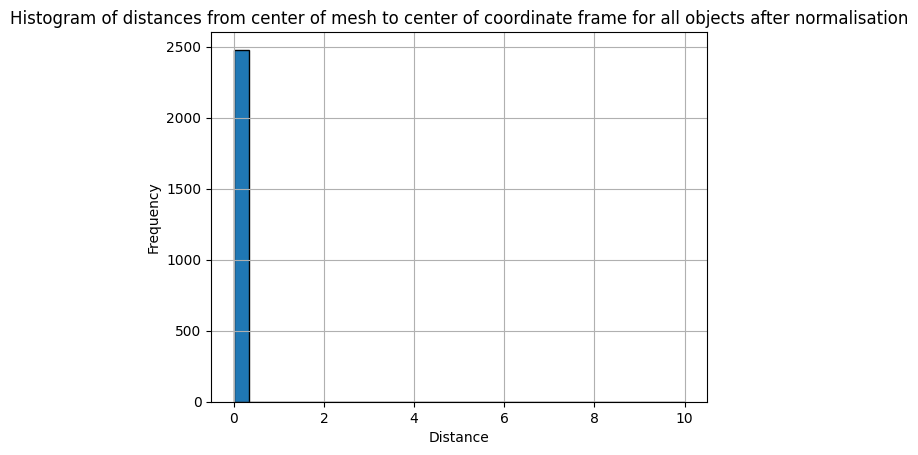

In [141]:

plt.hist(dist_to_center_list_normailzed, bins=30, range=[0, 10], edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Distance')
plt.title('Histogram of distances from center of mesh to center of coordinate frame for all objects after normalisation')
plt.grid(True)

# Display the histogram
plt.show()

***Test rotation normalization***

In [111]:

# import required libraries
from numpy.linalg import norm

def cosine_similarity(v1, v2):
    cosine = np.dot(v1,v2)/(norm(v1)*norm(v2))
    return cosine
    
def test_rotation(dbpath):
    cosine_similarity_list = []
    x = np.array([1,0,0])
    y = np.array([0,1,0])
    z = np.array([0,0,1])
    for class_folder in os.listdir(dbpath):
        # Construct the full path to the subfolder
        class_folder_path = os.path.join(dbpath, class_folder)
        
        # Check if the item in the directory is a directory (to skip files)
        if os.path.isdir(class_folder_path):
            # Assuming the class folder name is the class name
            class_name = class_folder
            
            # Iterate through .obj files in the subfolder
            for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
                mesh = o3d.io.read_triangle_mesh(obj_file_path)
                eigen_vectors,_ = get_eigen_vectors(mesh)
                print(eigen_vectors)
                x_similarity = cosine_similarity(x, np.abs(eigen_vectors[0]))
                y_similarity = cosine_similarity(y, np.abs(eigen_vectors[1]))
                z_similarity = cosine_similarity(z, np.abs(eigen_vectors[2]))
                cosine_similarity_list.append(x_similarity)
                cosine_similarity_list.append(y_similarity)
                cosine_similarity_list.append(z_similarity)
                
                print(x_similarity, y_similarity, z_similarity)
    return cosine_similarity_list

In [112]:
dbpath = r"./database/"
rotation_list = test_rotation(dbpath)

[array([ 1.37933137e-03, -9.99998671e-01, -8.68739279e-04]), array([-0.860536  , -0.00162949,  0.50938703]), array([-5.09387767e-01,  4.49679127e-05, -8.60537100e-01])]
0.00137933137058403 0.0016294909791006432 0.860537100208795
[array([ 1.08941545e-03, -9.99999204e-01, -6.36692685e-04]), array([-0.99985918, -0.00109992,  0.01674537]), array([-1.67460613e-02,  6.18360358e-04, -9.99859584e-01])]
0.0010894154538565132 0.0010999245768555305 0.999859583672866
[array([ 0.00532142,  0.99998422, -0.00179977]), array([0.00995386, 0.00174674, 0.99994893]), array([ 0.9999363 , -0.00533906, -0.0099444 ])]
0.005321418324273159 0.0017467389560633466 0.00994440283759856
[array([0.00116887, 0.99999145, 0.00396722]), array([ 0.99997913, -0.00119405,  0.00634922]), array([ 0.00635391,  0.00395971, -0.99997197])]
0.0011688742834545976 0.0011940488400643756 0.9999719738859777
[array([-2.07843352e-04, -9.99999978e-01, -1.26114748e-08]), array([-9.99999978e-01,  2.07843352e-04,  1.48961560e-06]), array([-1

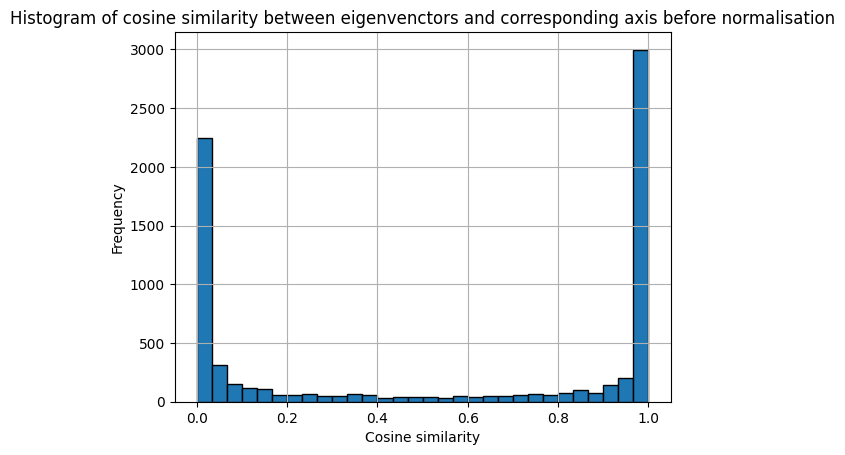

In [113]:
plt.hist(rotation_list, bins=30, edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Cosine similarity')
plt.title('Histogram of cosine similarity between eigenvenctors and corresponding axis before normalisation')
plt.grid(True)

# Display the histogram
plt.show()

In [114]:
dbpath = r"./resampled3/"
rotation_list_normalized = test_rotation(dbpath)

[array([1.00000000e+00, 2.97353222e-09, 5.26486185e-09]), array([ 2.97338864e-09, -1.00000000e+00,  2.72710110e-05]), array([ 5.26494294e-09, -2.72710110e-05, -1.00000000e+00])]
1.0 0.9999999996281461 0.9999999996281461
[array([ 1.00000000e+00,  2.10351391e-08, -7.57293367e-10]), array([ 2.10351593e-08, -1.00000000e+00,  2.66558529e-05]), array([-7.56732657e-10, -2.66558529e-05, -1.00000000e+00])]
0.9999999999999998 0.9999999996447326 0.9999999996447329
[array([ 1.00000000e+00,  2.54734270e-08, -3.96903115e-08]), array([-2.54734628e-08,  1.00000000e+00, -9.02123902e-07]), array([3.96902885e-08, 9.02123903e-07, 1.00000000e+00])]
0.9999999999999989 0.9999999999995928 0.9999999999995923
[array([ 1.00000000e+00,  7.86630015e-09, -8.68290236e-08]), array([-7.86638888e-09,  1.00000000e+00, -1.02183568e-06]), array([8.68290155e-08, 1.02183568e-06, 1.00000000e+00])]
0.9999999999999962 0.999999999999478 0.9999999999994743
[array([ 1.00000000e+00, -1.32001946e-07,  4.28666010e-08]), array([-1.32

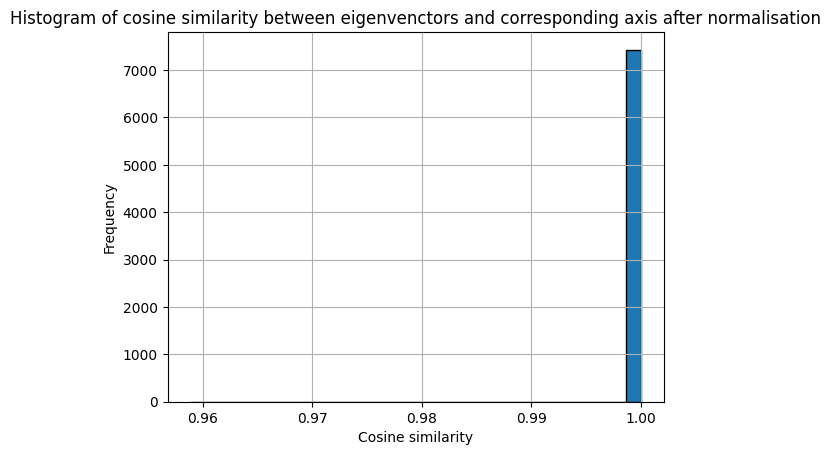

In [115]:
plt.hist(rotation_list_normalized, bins=30, edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Cosine similarity')
plt.title('Histogram of cosine similarity between eigenvenctors and corresponding axis after normalisation')
plt.grid(True)

# Display the histogram
plt.show()

***Test flip***

In [116]:
def test_flip(dbpath):
    mass_center_list = []

    for class_folder in os.listdir(dbpath):
        # Construct the full path to the subfolder
        class_folder_path = os.path.join(dbpath, class_folder)
        
        # Check if the item in the directory is a directory (to skip files)
        if os.path.isdir(class_folder_path):
            # Assuming the class folder name is the class name
            class_name = class_folder
            
            # Iterate through .obj files in the subfolder
            for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
                mesh = o3d.io.read_triangle_mesh(obj_file_path)
                mass = [0, 0, 0]
                for triangle in mesh.triangles:
                    center = [0, 0, 0]
                    for v in triangle:
                        vertex = mesh.vertices[v]
                        center += vertex
                    center = center / 3
                    
                    for i, C in enumerate(center):
                        mass[i] += np.sign(C) * (C * C)
                
                for i, C in enumerate(mass):
                    mass_center_list.append(C)

    return mass_center_list

In [117]:
#needs to be all negative when flipping is executed correctly
dbpath = r"./resampled3/"
flip_list_normalized = test_flip(dbpath)

In [118]:
max(flip_list_normalized)

1.2417025062563813e-05

In [119]:
num = 0
 
# using while loop     
while(num < len(flip_list_normalized)):
     
    # checking condition
    if flip_list_normalized[num] >= 0:
        print(flip_list_normalized[num], end = " ")
     
    # increment num 
    num += 1

9.235593323247103e-08 5.754996829053505e-06 1.2417025062563813e-05 

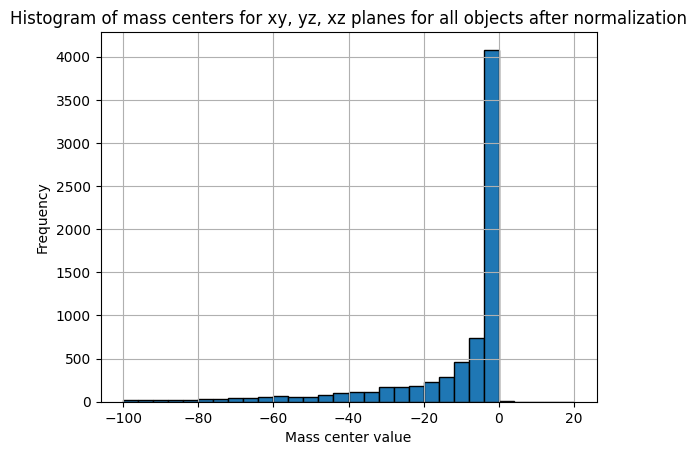

In [120]:
plt.hist(flip_list_normalized, bins=30, range=[-100,20], edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Mass center value')
plt.title('Histogram of mass centers for xy, yz, xz planes for all objects after normalization')
plt.grid(True)

# Display the histogram
plt.show()

In [121]:
dbpath = r"./database/"
flip_list = test_flip(dbpath)

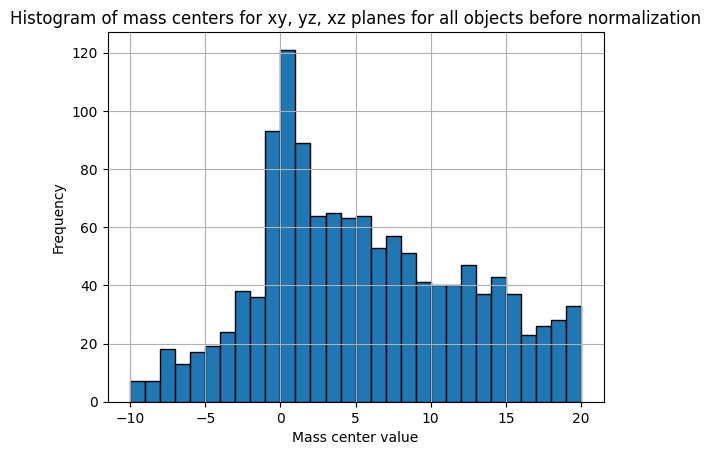

In [122]:
plt.hist(flip_list, bins=30, range=[-10,20], edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Mass center value')
plt.title('Histogram of mass centers for xy, yz, xz planes for all objects before normalization')
plt.grid(True)

# Display the histogram
plt.show()

***test scaling***

In [123]:
def test_scaling(dbpath):
    max_length_list = []

    for class_folder in os.listdir(dbpath):
        # Construct the full path to the subfolder
        class_folder_path = os.path.join(dbpath, class_folder)
        
        # Check if the item in the directory is a directory (to skip files)
        if os.path.isdir(class_folder_path):
            # Assuming the class folder name is the class name
            class_name = class_folder
            
            # Iterate through .obj files in the subfolder
            for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
                mesh = o3d.io.read_triangle_mesh(obj_file_path)
                max_length = max(mesh.get_max_bound() - mesh.get_min_bound())
                max_length_list.append(max_length)
    return max_length_list

In [124]:
dbpath = r"./resampled3/"
max_length_list_normalized = test_scaling(dbpath)

0.9999999701976776


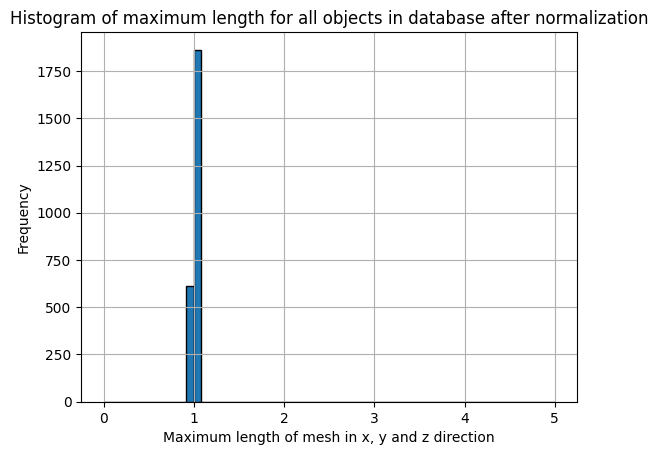

In [137]:
print(min(max_length_list_normalized))
plt.hist(max_length_list_normalized, bins=60, range = [0, 5], edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Maximum length of mesh in x, y and z direction')
plt.title('Histogram of maximum length for all objects in database after normalization')
plt.grid(True)

# Display the histogram
plt.show()

In [126]:
dbpath = r"./database/"
max_length_list = test_scaling(dbpath)

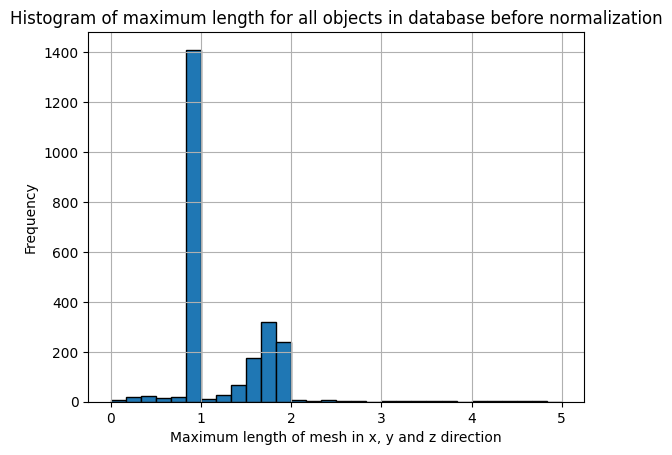

In [138]:
plt.hist(max_length_list, bins=30, range=[0,5], edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Maximum length of mesh in x, y and z direction')
plt.title('Histogram of maximum length for all objects in database before normalization')
plt.grid(True)

# Display the histogram
plt.show()